# Training and evaluation notebook
Multi-class classification based on only bands.

In [3]:
## imports
import glob
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, accuracy_score

## 1. Construct dataset

In [4]:
# Simply reading the formerly created pickle file, changing it's name to 'merged_df'
# To confirm, you can load and view the combined dataset
with open("combined_dataset.pkl", 'rb') as file:
    merged_df = pd.read_pickle(file)

merged_df


,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,sample_location_id,class
0,0.00495,0.01885,0.03610,0.05020,0.09065,0.13930,0.15855,0.18270,0.19205,0.19175,0.20290,0.1097,201701,2
1,0.01040,0.02405,0.03980,0.05720,0.10385,0.16755,0.19370,0.21600,0.23420,0.24700,0.22290,0.1204,201701,2
2,0.01510,0.02905,0.06635,0.04515,0.12920,0.38280,0.47410,0.49955,0.50775,0.50890,0.24765,0.1219,201701,2
3,0.01345,0.02925,0.06315,0.04920,0.12335,0.28515,0.33710,0.39055,0.37655,0.42050,0.23555,0.1175,201701,2
4,0.01575,0.02970,0.06900,0.04870,0.13360,0.39940,0.49485,0.52430,0.53900,0.48935,0.23950,0.1177,201701,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1152806,0.03720,0.04660,0.06660,0.08560,0.13300,0.21200,0.24360,0.26880,0.28690,0.27960,0.28600,0.1640,202312,2
1152807,0.03840,0.04250,0.07690,0.08000,0.14000,0.25190,0.28530,0.34760,0.33920,0.32180,0.29830,0.1563,202312,2
1152808,0.04280,0.04960,0.06970,0.08880,0.12820,0.18960,0.21990,0.25540,0.25480,0.25390,0.27920,0.1567,202312,2
1152809,0.03170,0.04110,0.06480,0.07660,0.13350,0.23340,0.27290,0.30900,0.30940,0.29640,0.30290,0.1617,202312,2


### Removing locations

In [5]:
# Assuming 'merged_df' is your pandas DataFrame
merged_df = merged_df.drop('sample_location_id', axis=1)

In [6]:
# renaming 'class' column to 'classes' to fix python error
merged_df = merged_df.rename(columns={'class': 'classes'})

## Constructing training and test set 



0 = actively eroding,
1 = drained, 
2 = modified, 
3 = bare peat, 
4 = restored, 

In [7]:
# Assuming merged_df is your pandas DataFrame
# Shuffle the DataFrame using a random seed, for example, seed=42
merged_df = merged_df.sample(frac=1, random_state=42).reset_index(drop=True)
merged_df

,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,classes
0,0.0314,0.04940,0.07090,0.0865,0.1320,0.21270,0.24250,0.27180,0.27720,0.27020,0.31170,0.17690,1
1,0.0372,0.03460,0.06320,0.0552,0.1153,0.22680,0.26230,0.33740,0.31370,0.32460,0.25210,0.13750,4
2,0.0140,0.02225,0.03620,0.0311,0.0558,0.16955,0.20515,0.21160,0.22540,0.23985,0.10470,0.05580,1
3,0.0508,0.05240,0.06040,0.0770,0.0979,0.13440,0.15750,0.15280,0.17550,0.20040,0.27810,0.19370,4
4,0.0264,0.03410,0.04770,0.0682,0.0859,0.12390,0.13830,0.17360,0.16880,0.18970,0.23740,0.17300,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1152806,0.0227,0.02990,0.04540,0.0475,0.1026,0.18080,0.20390,0.21860,0.23660,0.20940,0.22070,0.11800,1
1152807,0.0355,0.05275,0.07225,0.0825,0.1253,0.21130,0.23830,0.26315,0.27845,0.28715,0.24615,0.12935,1
1152808,0.0225,0.03050,0.04650,0.0437,0.1125,0.22960,0.26410,0.27620,0.29440,0.28600,0.18450,0.08900,2
1152809,0.0342,0.02980,0.05680,0.0466,0.1115,0.24880,0.29190,0.32360,0.33000,0.34590,0.23690,0.11060,1


In [8]:
from sklearn.model_selection import train_test_split

# Assuming your features are all columns except 'classes', and 'classes' is the target variable
X = merged_df.drop('classes', axis=1)  # Features
y = merged_df['classes']  # Target variable

# Perform the split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# X_train and y_train will now contain 70% of the data, X_test and y_test will contain 30%

## Hyperparameter optimisation

In [9]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def objective(trial):
    # Hyperparameters to tune
    n_estimators = trial.suggest_int('n_estimators', 50, 400)
    max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
    # Ensuring min_samples_split is an int >= 2
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    # Ensuring min_samples_leaf is a float within (0.0, 0.5], you could also use suggest_int if you want specific integer values
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)

    # Initialize the classifier with the current hyperparameters
    clf = RandomForestClassifier(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    # Train the classifier
    clf.fit(X_train, y_train)

    # Predict on the validation set
    predictions = clf.predict(X_test)

    # Compute and return the accuracy
    accuracy = accuracy_score(y_test, predictions)
    return accuracy


In [10]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)  # Adjust the number of trials as needed

print(f"Best trial: {study.best_trial.params}")


[I 2024-02-12 14:31:02,978] A new study created in memory with name: no-name-5a385424-a6a3-41bc-a6da-a929bec41813
[I 2024-02-12 14:36:58,993] Trial 0 finished with value: 0.8121609743121176 and parameters: {'n_estimators': 96, 'max_depth': 24, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8121609743121176.
[I 2024-02-12 14:37:57,881] Trial 1 finished with value: 0.5018968089658922 and parameters: {'n_estimators': 66, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8121609743121176.
[I 2024-02-12 14:42:35,513] Trial 2 finished with value: 0.6890332057228115 and parameters: {'n_estimators': 113, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8121609743121176.
[I 2024-02-12 14:47:36,644] Trial 3 finished with value: 0.5281051572385237 and parameters: {'n_estimators': 262, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.

Best trial: {'n_estimators': 278, 'max_depth': 29, 'min_samples_split': 4, 'min_samples_leaf': 1}


In [64]:
import pandas as pd

# Convert the best trial's parameters to a DataFrame for easy CSV saving
best_trial_params_df = pd.DataFrame([study.best_trial.params])

# Save the DataFrame containing the best trial's parameters to a CSV file
best_trial_params_df.to_csv('best_trial_hyperparameters_with_indices.csv', index=False)

# Print the best trial's hyperparameters
print("Best trial's hyperparameters with indices:")
print(best_trial_params_df.to_string(index=False))

print("\nSaved the best trial's hyperparameters to 'best_trial_hyperparameters_with_indices.csv'")

Best trial's hyperparameters with indices:
 n_estimators  max_depth  min_samples_split  min_samples_leaf
          395          4           0.200921          0.100345

Saved the best trial's hyperparameters to 'best_trial_hyperparameters_with_indices.csv'


## Training / evaluating 

Start with a baseline model, the simplest possible model, using logistic regression on the train and test sets you sorted out above. This establishes your baseline. 

Here is the logistic regression model:

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, cohen_kappa_score, accuracy_score
from sklearn.preprocessing import StandardScaler

# Initialize the Logistic Regression classifier
log_reg = LogisticRegression(max_iter=1000) # Increase max_iter if convergence warnings occur

# Train the classifier on the training set
log_reg.fit(X_train, y_train)

# Predict on the test set
log_reg_predictions = log_reg.predict(X_test)

# Predict on the test set
lr_predictions = log_reg.predict(X_test)

# Calculate metrics
lr_precision = precision_score(y_test, lr_predictions, average='weighted')
log_reg_accuracy = accuracy_score(y_test, log_reg_predictions)
lr_recall = recall_score(y_test, lr_predictions, average='weighted')
lr_f1 = f1_score(y_test, lr_predictions, average='weighted')
lr_kappa = cohen_kappa_score(y_test, lr_predictions)

# Print metrics
print("Logistic Regression Performance:")
print(f"Precision: {lr_precision}")
print(f'Logistic Regression Accuracy: {log_reg_accuracy}')
print(f"Recall: {lr_recall}")
print(f"F1 Score: {lr_f1}")
print(f"Cohen's Kappa: {lr_kappa}")

Logistic Regression Performance:
Precision: 0.47501679689911197
Logistic Regression Accuracy: 0.4905969165288396
Recall: 0.4905969165288396
F1 Score: 0.39595698410377583
Cohen's Kappa: 0.17423768428358866


An RF model:

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Best trial: {'n_estimators': 278, 'max_depth': 29, 'min_samples_split': 4, 'min_samples_leaf': 1}
# 'n_estimators': 158, 'max_depth': 8, 'min_samples_split': 0.48214045435683095, 'min_samples_leaf': 0.48921314423047646

# Assuming you have your optimized hyperparameters, for example:
optimized_hyperparameters = {
    'n_estimators': 278,
    'max_depth': 29,
    'min_samples_split': 4,
    'min_samples_leaf': 1, 
    # Include other hyperparameters as necessary
}

# Initialize the RandomForestClassifier with optimized hyperparameters
clf = RandomForestClassifier(
    n_estimators=optimized_hyperparameters['n_estimators'],
    max_depth=optimized_hyperparameters['max_depth'],
    min_samples_split=optimized_hyperparameters['min_samples_split'],
    min_samples_leaf=optimized_hyperparameters['min_samples_leaf'],
    random_state=42  # Ensuring reproducibility
)

# Train the classifier on the training set
clf.fit(X_train, y_train)

# Predict on the test set
predictions = clf.predict(X_test)

# Compute and display the accuracy
accuracy = accuracy_score(y_test, predictions)
rf_precision = precision_score(y_test, predictions, average='weighted')
rf_recall = recall_score(y_test, predictions, average='weighted')
rf_f1 = f1_score(y_test, predictions, average='weighted')
rf_kappa = cohen_kappa_score(y_test, predictions)

# Print metrics
print("RandomForest Performance:")
print(f"Precision: {rf_precision}")
print(f"Recall: {rf_recall}")
print(f"F1 Score: {rf_f1}")
print(f"Cohen's Kappa: {rf_kappa}")
print(f'Optimized RandomForest Accuracy: {accuracy}')

RandomForest Performance:
Precision: 0.8600071465026637
Recall: 0.8586356854535571
F1 Score: 0.8553792340033315
Cohen's Kappa: 0.7981713969729736
Optimized RandomForest Accuracy: 0.8586356854535571


In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

# Assuming clf is already trained and X_train, y_train, X_test, y_test are defined

# Predictions on the test set
test_predictions = clf.predict(X_test)

# Compute test metrics
test_accuracy = accuracy_score(y_test, test_predictions)
test_precision = precision_score(y_test, test_predictions, average='weighted')
test_recall = recall_score(y_test, test_predictions, average='weighted')
test_f1 = f1_score(y_test, test_predictions, average='weighted')
test_kappa = cohen_kappa_score(y_test, test_predictions)

# Predictions on the training set
train_predictions = clf.predict(X_train)

# Compute training metrics
train_accuracy = accuracy_score(y_train, train_predictions)
train_precision = precision_score(y_train, train_predictions, average='weighted')
train_recall = recall_score(y_train, train_predictions, average='weighted')
train_f1 = f1_score(y_train, train_predictions, average='weighted')
train_kappa = cohen_kappa_score(y_train, train_predictions)

# Print comparison
print("Training vs Test Performance Comparison:")
print(f"Training Accuracy: {train_accuracy} vs Test Accuracy: {test_accuracy}")
print(f"Training Precision: {train_precision} vs Test Precision: {test_precision}")
print(f"Training Recall: {train_recall} vs Test Recall: {test_recall}")
print(f"Training F1 Score: {train_f1} vs Test F1: {test_f1}")
print(f"Training Cohen's Kappa: {train_kappa} vs Test Cohen's Kappa: {test_kappa}")

Training vs Test Performance Comparison:
Training Accuracy: 0.9790784505438265 vs Test Accuracy: 0.8586356854535571
Training Precision: 0.9790588380989428 vs Test Precision: 0.8600071465026637
Training Recall: 0.9790784505438265 vs Test Recall: 0.8586356854535571
Training F1 Score: 0.9789666243138281 vs Test F1: 0.8553792340033315
Training Cohen's Kappa: 0.9707344352582721 vs Test Cohen's Kappa: 0.7981713969729736


## Confusion matrix

- You'll also want to output an aggregated prediction confusion matrix (from the cross-validation), preferably as a seaborn (sns) figure. 

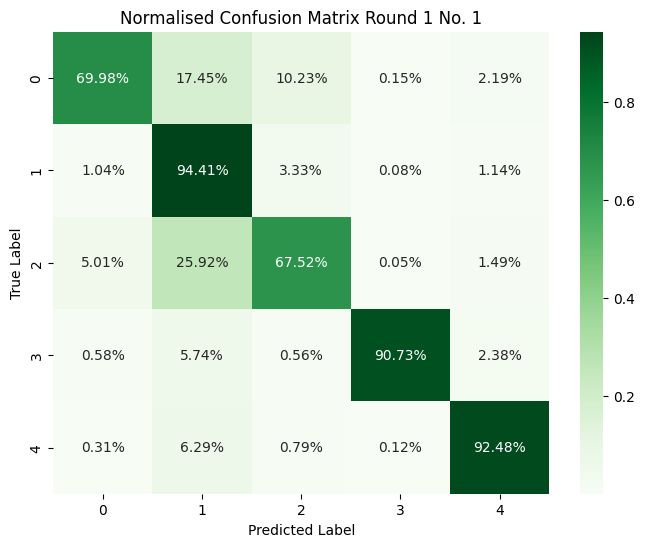

In [16]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming predictions, y_test are already defined

# Compute the normalized confusion matrix
cm_normalized = confusion_matrix(y_test, predictions, labels=[0, 1, 2, 3, 4], normalize='true')

# Visualize the normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt=".2%", cmap="Greens", xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.title('Normalised Confusion Matrix Round 1 No. 1')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


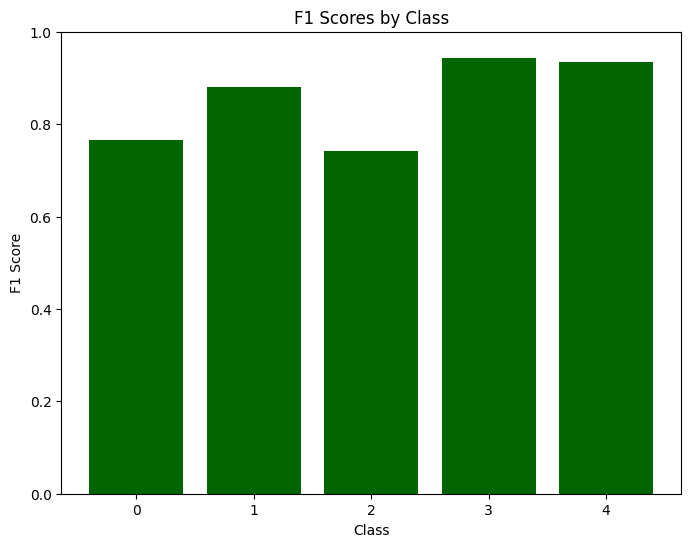

In [28]:
from sklearn.metrics import f1_score
import numpy as np

# Assuming predictions and y_test are already defined
# Calculate F1 scores for each class
f1_scores_per_class = f1_score(y_test, predictions, labels=[0, 1, 2, 3, 4], average=None)

# Visualize F1 scores for each class
plt.figure(figsize=(8, 6))
classes = [0, 1, 2, 3, 4]
plt.bar(classes, f1_scores_per_class, color='darkgreen')
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.title('F1 Scores by Class')
plt.xticks(classes)
plt.ylim(0, 1)  # F1 scores range from 0 to 1
plt.show()

## Feature permutation importance

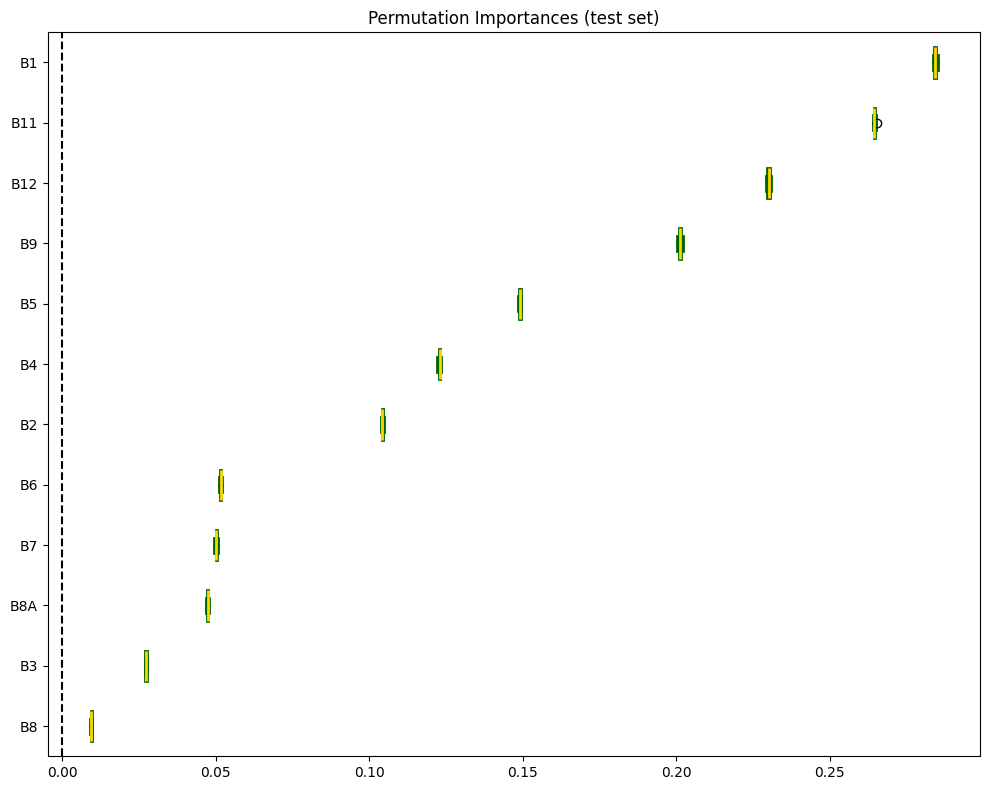

In [17]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import precision_score, recall_score, f1_score, cohen_kappa_score
import matplotlib.pyplot as plt
import numpy as np

# Ensure these imports for computing metrics
from sklearn.metrics import accuracy_score

# Your RandomForestClassifier `clf` has been trained on a multi-class dataset

# Compute permutation importance
result = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=1)

# Sorting features by importance
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(10, 8))
labels = X_test.columns[sorted_idx]
bp = ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=labels, patch_artist=True)

# Customizing the boxplot colors
for box in bp['boxes']:
    box.set(color='darkgreen', linewidth=2)
    box.set(facecolor='lightgreen')  # Adjust fill color for visibility

# Whiskers, caps, and medians customization
for whisker in bp['whiskers']:
    whisker.set(color='darkgreen', linewidth=2)
for cap in bp['caps']:
    cap.set(color='darkgreen', linewidth=2)
for median in bp['medians']:
    median.set(color='gold', linewidth=2)

ax.axvline(x=0, color="k", linestyle="--")
ax.set_title("Permutation Importances (test set)")
plt.tight_layout()
plt.show()